**В лекции был приведен пример использования Truncated SVD для сжатия картинок. Задание - привести другие примеры применения SVD к картинкам.**

### 1. Denoising
SVD может быть использован для снижения уровня шума в изображениях. Существуют разные подходы, здесь рассмотрим базовую идею этих алгоритмов на примере grayscale изображения размера 512х512.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage.io import imread
from skimage import filters

(-0.5, 511.5, 511.5, -0.5)

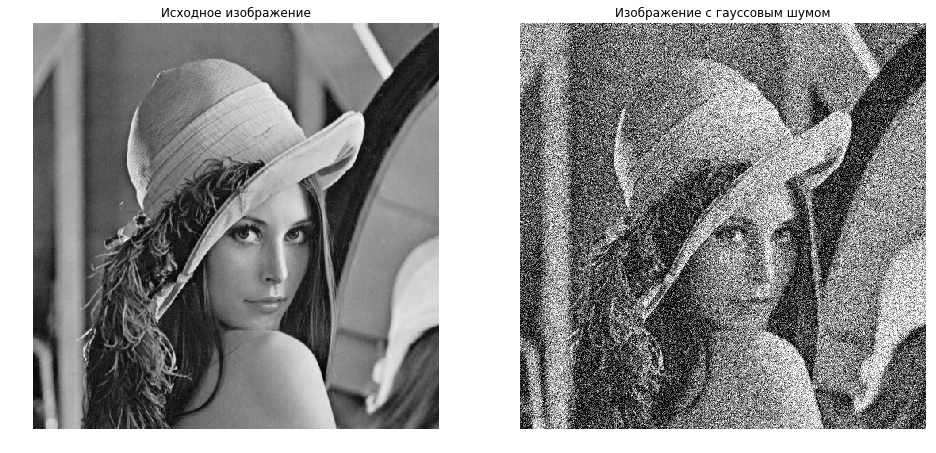

In [39]:
image = imread("lena.jpg")
image = sk.color.rgb2gray(image)
image_noise = sk.util.random_noise(image,var=0.05)
fig=plt.figure(figsize=(16, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Исходное изображение")
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(image_noise, cmap='gray')
plt.title("Изображение с гауссовым шумом")
plt.axis('off')

Для снижения уровня шума предлагается использововать truncated SVD зашумленного изображения

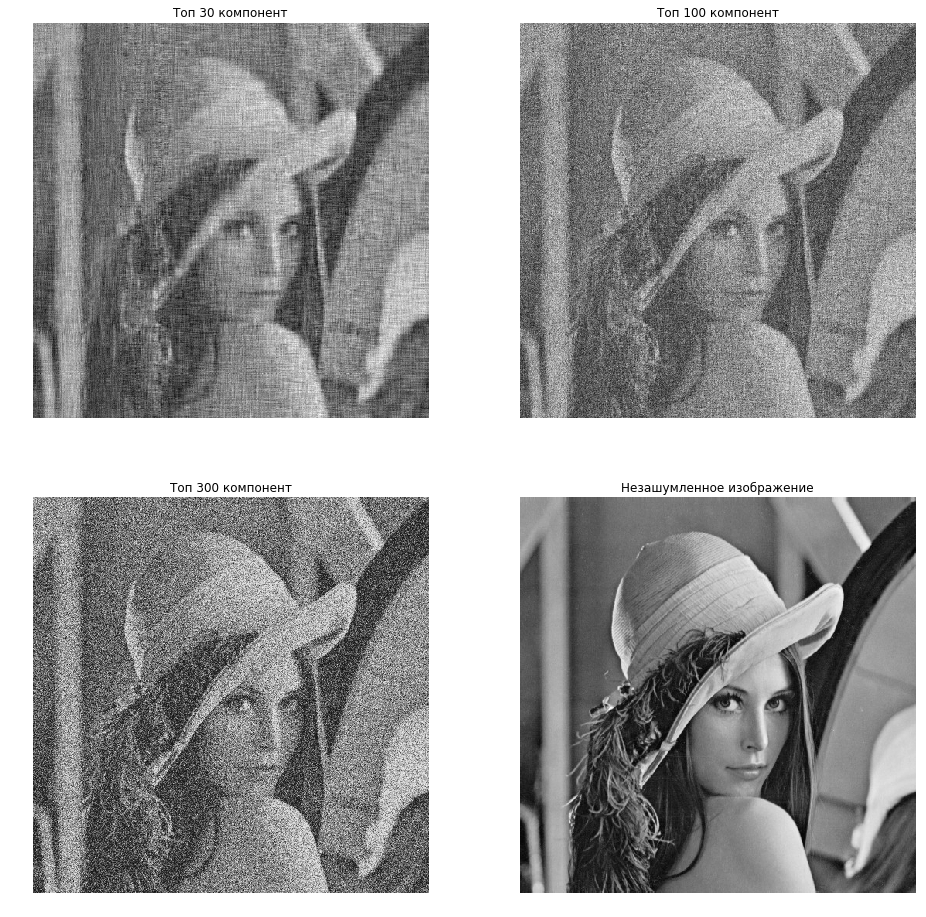

In [40]:
U, S, V = np.linalg.svd(image_noise)
denoise10 = np.dot(U[:, :30] * S[:30], V[:30, :])
denoise50 = np.dot(U[:, :100] * S[:100], V[:100, :])
denoise100 = np.dot(U[:, :300] * S[:300], V[:300, :])
fig=plt.figure(figsize=(16, 16))
captures = ['Топ 30 компонент', 'Топ 100 компонент', 'Топ 300 компонент', "Незашумленное изображение"]
images = [denoise10, denoise50, denoise100, image]
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1], cmap='gray')
    plt.title(captures[i-1])
    plt.axis('off')
plt.show()

Сравним результат с сверткой с гауссовым фильтром

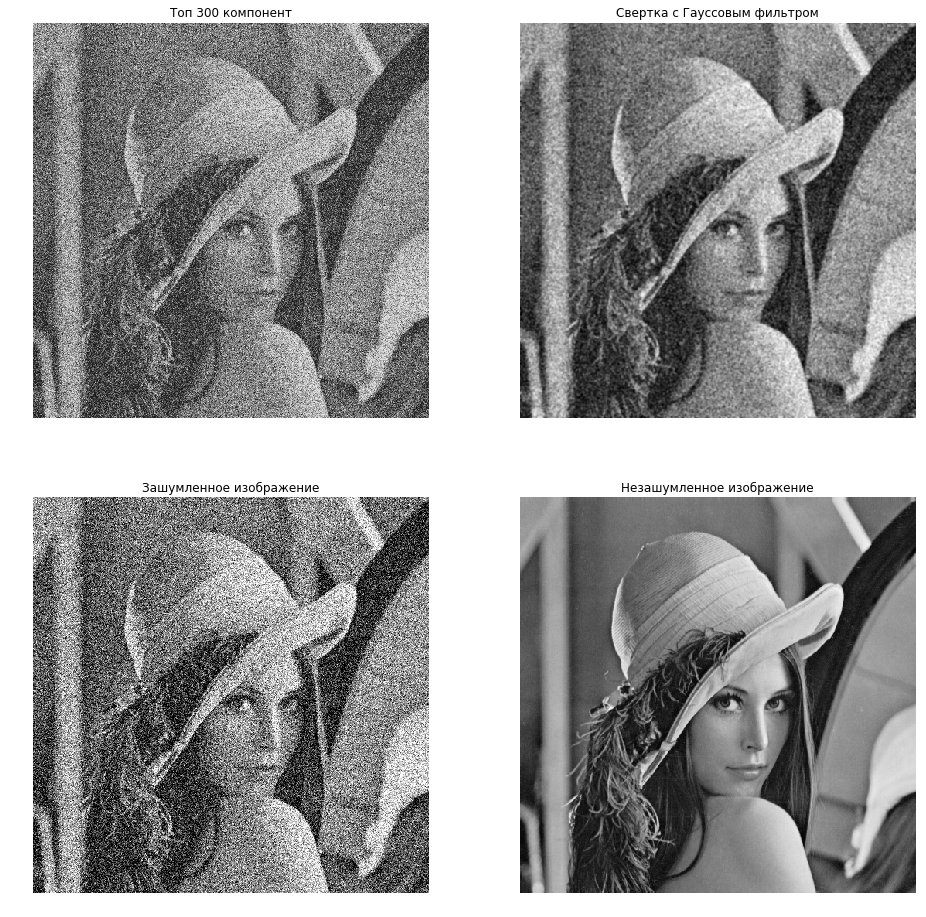

In [41]:
gauss_filtered = skimage.filters.gaussian(image_noise)
captures = ['Топ 300 компонент', "Свертка с Гауссовым фильтром", "Зашумленное изображение", "Незашумленное изображение"]
images = [denoise100, gauss_filtered, image_noise, image]
columns = 2
rows = 2
fig=plt.figure(figsize=(16, 16))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1], cmap='gray')
    plt.title(captures[i-1])
    plt.axis('off')
plt.show()

Видно, что свертка с гауссовым фильтром работает лучше, при этом очевидно работает быстрее.

### 2. Признаковое описание

SVD  может быть использован для получения признакового описания картинки, но эти принаки будут адекватными лишь при ряде ограничений на изображения. Примером применения SVD для построения признакового пространства явлется алгоритм Eigenface, решающий задачу идентификации человека по изображению его лица.

Данный алгоритм предполагает, что 
1. Все изображения имеют одинаковые размерности по ширине и высоте;
2. Изображения представлены в оттенках серого;
3. Изображения должны быть центрированы, т.е. глаза, нос, губы должны находиться на приблизительно одном уровне. 

На этапе обучения создается обучающая выборка, строится ковариационная матрица, вычисляются собственные вектора и значения, определяются их веса.

* Получаемое на вход изображение в обобщенном виде представляет собой матрицу . Это изображение преобразуется в один вектор путём конкатенации строк. 
* На данном шаге рассчитывается среднее изображение M. После чего создается новый набор векторов, каждый из которых представляет собой один из первоначальных изображений за вычетом среднего.
* Затем вычисляются собственные вектора и собственные значения матрицы ковариаций, и выбирают k наибольших значений и соотвествующих им собственных значений.

Для получения собственных векторов часто используется SVD разложение, так как оно эффективно реализовано в общедоступных библиотеках. Выведем соотвествующие формулы:

Пусть $X \in R^{N \times D}$ - N изображений, с суммарной пространственной размерностью D (после вытягивания в вектор). Будем считать, что X центрирован, тогда 
covariance(X) = $\frac{XX^T}{(N-1)}$, а SVD(X) = $U \Sigma V$ Тогда

$XX^T = U \Sigma^2 U^T$, тк V - унитарная матрица и $VV^T = I$ , а так как матрица ковариаций симметричная covariance(X) = $C D C^T$, где C - ортогональная матрица из собственных векторов, а D - диагональная матрица собственных значений.

Тогда $C = U, D = \frac{\Sigma^2}{N-1}$

Для идентификации мы проецируем обучающие изображения, умножив матрицу X на матрицу собственных векторов матрицы ковариаций. Тестовое изображение аналогично вытягиваем в вектор, вычитаем среднее из обучения и также умножаем на матрицу собственных значений. Затем используя новое признаковое описание находим ближайшего соседа из обучающей выборки, используя Евклидово расстояние или расстояние Махаланобиса.